# Data Loading
First, reuse the code from HW1 to download and read the data.

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [5]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [6]:
train_texts[:10] # Just checking the examples in train_text

['Love has one law; Make happy the person you love. In the same way friendship has one law; Never make ur friend feel alone until you are alive.... Gud night',
 'Same as kallis dismissial in 2nd test:-).',
 'Arun can u transfr me d amt',
 "The  &lt;#&gt; g that i saw a few days ago, the guy wants sell wifi only for  &lt;#&gt;  and with 3g for  &lt;#&gt; . That's why i blanked him.",
 'Tell me whos this pls:-)',
 'R we going with the  &lt;#&gt;  bus?',
 "Sorry, I'll call later",
 'O was not into fps then.',
 "Alright, we're all set here, text the man",
 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468']

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.





In [7]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2021-05-05 11:48:47--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 74.125.23.113, 74.125.23.102, 74.125.23.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.23.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ugv9s4jsdkno0kb341hjrsvbe2dp983/1620215325000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2021-05-05 11:48:52--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ugv9s4jsdkno0kb341hjrsvbe2dp983/1620215325000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.204.132|

## Load GloVe Embeddings

In [8]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

## Import packages

In [9]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

     |████████████████████████████████| 901kB 4.1MB/s 


# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [10]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

In [11]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[837, 33, 50, 266, 91, 161, 1753, 2, 901, 83, 1, 8, 2, 217, 181, 4583, 33, 50, 266, 91, 334, 161, 10576, 1411, 1000, 1487, 209, 83, 34, 2979, 6940, 1, 366], [217, 21, 18609, 1, 8, 2768, 730, 47, 13, 26, 4], [33473, 88, 6481, 1, 287, 1970, 29099], [2, 725, 18811, 91, 2751, 725, 16537, 91, 3412, 14, 43, 824, 9, 308, 251, 365, 3, 2, 1858, 1027, 1245, 39549, 93, 12, 725, 18811, 91, 2751, 725, 16537, 91, 7, 19, 19190, 12, 725, 18811, 91, 2751, 725, 16537, 91, 4, 14, 1, 740, 43, 38307, 105, 4], [1363, 287, 1, 39, 1, 47, 13, 26]]

Train labels first 5 examples:
 [0, 0, 0, 0, 0]


# Create DataLoaders 

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list

        """
        label_list = [datum[1] for datum in batch]
        max_batch_seq_len = max(len(datum[0]) for datum in batch)
        if max_batch_seq_len > self.max_sent_length:
            max_batch_seq_len = self.max_sent_length

        for datum in batch:
            padded_vec = np.pad(np.array(datum[0]), 
                                    pad_width=((0,max_batch_seq_len-len(datum[0]))), 
                                    mode="constant", constant_values=0)
            data_list.append(padded_vec)
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.LongTensor(label_list)        

        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an batch from train_loader.


In [13]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 49])
data_batch:  tensor([[ 4004,    43,   915,  ...,     0,     0,     0],
        [46083,   436,     0,  ...,     0,     0,     0],
        [   12,  1565,    13,  ...,     0,     0,     0],
        ...,
        [ 1536,  1536,     1,  ...,     0,     0,     0],
        [  826, 10576,   364,  ...,     0,     0,     0],
        [13417,   165,  6481,  ...,     0,     0,     0]])
labels:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


# Build a BiLSTM Classifier

In [16]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = None
        self.lstm = None
        self.non_linearity = None # For example, ReLU
        self.clf = None # classifier layer
        """
           define the components of your BiLSTM Classifier model

        """
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p = dropout_prob)
        self.lstm = nn.LSTM(embeddings.shape[1], hidden_size, num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=0.3)
        self.relu = nn.ReLU()
        # self.clf = nn.Linear(hidden_size*2, num_classes)
        self.clf = nn.Linear(hidden_size, num_classes)
    
    def load_pretrained_embeddings(self, embeddings):

        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None

        batch_size = inputs.size()[0] # inputs : batch_sz, seq_len
        out = self.dropout(self.embedding_layer(inputs))
        out, _ = self.lstm(out, None)
        out = out.mean(1)
        out = self.relu(out)
        #out = self.relu(torch.mean(out,1))
        logits = self.clf(out)
        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [17]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()

    n_correct = n_total = 0 
    model.eval()
    with torch.no_grad():
        
        for (data_batch, batch_labels) in dataloader:
            out = model(data_batch.to(device))
            max_scores, preds = out.max(dim=1)
            #preds = np.argmax(out, axis=1).cpu().numpy()
            n_correct += np.sum(preds.cpu().numpy() == batch_labels.numpy())
            n_total += out.shape[0]
    accuracy = n_correct*1.0/n_total
    return accuracy 

# Initialize the BiLSTM classifier model, criterion and optimizer


In [18]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=False
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Train model with early stopping 

In [19]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
        
    # The end of a training epoch 


    cur_val_accuracy = evaluate(model, val_loader, device=device)
    val_accuracy_history.append(cur_val_accuracy)
    print("epoch: {}, val_accuracy: {}".format(epoch+1, cur_val_accuracy))
    if cur_val_accuracy > best_val_accuracy:
        best_val_accuracy = cur_val_accuracy
        torch.save(model, 'best_model.pt')
        n_no_improve = 0
    else:
        n_no_improve += 1 
    if n_no_improve > early_stop_patience:
        print("Early stopped at epoch ",epoch)
        break

    

print("Best validation accuracy is: ", best_val_accuracy)

epoch: 1, val_accuracy: 0.9676646706586827
epoch: 2, val_accuracy: 0.9760479041916168
epoch: 3, val_accuracy: 0.9784431137724551
epoch: 4, val_accuracy: 0.9820359281437125
epoch: 5, val_accuracy: 0.9772455089820359
epoch: 6, val_accuracy: 0.9820359281437125
epoch: 7, val_accuracy: 0.9820359281437125
Early stopped at epoch  6
Best validation accuracy is:  0.9820359281437125


# Draw training curve 
X-axis: training steps, Y-axis: training loss

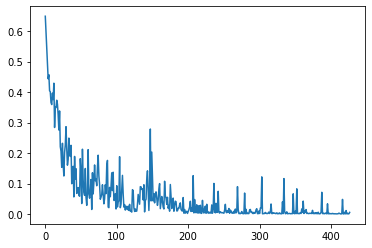

In [20]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

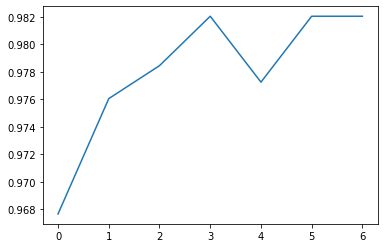

In [21]:
pd.Series(val_accuracy_history).plot()

# Test Accuracy

In [22]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)


print(test_accuracy)

0.9808383233532935
